# BoolQ Evaluation
This notebook pulls a model via Ollama and evaluates it on the BoolQ dataset

In [ ]:
# Install required packages
!pip install datasets requests tqdm pandas scikit-learn psutil
!apt install lshw
!curl -fsSL https://ollama.com/install.sh | sh

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
lshw is already the newest version (02.19.git.2021.06.19.996aaad9c7-2build1).
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
>>> Cleaning up old version at /usr/local/lib/ollama
>>> Installing ollama to /usr/local
>>> Downloading Linux amd64 bundle
############################################################################################# 100.0%
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> NVIDIA GPU installed.
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.


In [ ]:
import os
import threading
import json
import time
import psutil
import requests
import subprocess
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Set up ollama server
os.environ['OLLAMA_NUM_PARALLEL'] = '16'
os.environ['OLLAMA_FLASH_ATTENTION'] = '1'

def is_server_running():
    try:
        requests.get('http://localhost:11434/api/tags')
        return True
    except requests.exceptions.ConnectionError:
        return False

def wait_for_server(timeout=30):
    start_time = time.time()
    while time.time() - start_time < timeout:
        if is_server_running():
            return True
        time.sleep(1)
    return False

# Start server if not already running
if not is_server_running():
    server = threading.Thread(
        target=lambda: subprocess.run(['ollama', 'serve'], check=True),
        daemon=True
    )
    server.start()

    if not wait_for_server():
        raise RuntimeError("Ollama server failed to start within timeout")
else:
    print("Ollama server is already running")

In [ ]:
# Pull model using Ollama
!ollama pull smollm2:135m

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest 
pulling f535f83ec568... 100% ▕▏ 270 MB                         
pulling fbacade46b4d... 100% ▕▏   68 B                         
pulling d502d55c1d60... 100% ▕▏  675 B                         
pulling 58d1e17ffe51... 100% ▕▏  11 KB                         
pulling f02dd72bb242... 100% ▕▏   59 B                         
pulling b0f58c4c1a3c... 100% ▕▏  561 B                         
verifying sha256 digest 
writing manifest 
success 


In [ ]:
def query_ollama(prompt, model):
    """
    Send a query to the Ollama API and get the response
    """
    try:
        response = requests.post('http://localhost:11434/api/generate',
                               json={
                                   'model': model,
                                   'prompt': prompt,
                                   'stream': False
                               })
        response.raise_for_status()
        return response.json()['response']
    except Exception as e:
        raise RuntimeError(f"Error querying Ollama: {e}")

def format_prompt(question, passage):
    """
    Format the prompt for the model
    """
    return f"""Given the following passage and question, answer with only 'yes' or 'no'.

Passage: {passage}

Question: {question}

Answer:"""

def clean_response(response):
    """
    Clean the model's response to get just yes/no
    """
    response = response.lower().strip()
    if 'yes' in response:
        return 'yes'
    elif 'no' in response:
        return 'no'
    else:
        return 'invalid'

In [ ]:
# Load BoolQ dataset
print("Loading BoolQ dataset...")
dataset = load_dataset("boolq", split="validation")
print(f"Loaded {len(dataset)} examples")

Loading BoolQ dataset...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loaded 3270 examples


In [ ]:
# Evaluate model
print("Starting evaluation...")
results = []
predictions = []
ground_truth = []

# FIXED HERE: was range(range(len(dataset))) before
# not sure how this was working before and generated outputs
for idx in range(len(dataset)):
    example = dataset[idx]

    # Format prompt
    prompt = format_prompt(example['question'], example['passage'])

    # Get model response
    response = query_ollama(prompt, "smollm2:135m")
    cleaned_response = clean_response(response)

    # Store results
    results.append({
        'question': example['question'],
        'passage': example['passage'],
        'predicted': cleaned_response,
        'actual': 'yes' if example['answer'] else 'no',
        'correct': (cleaned_response == 'yes') == example['answer']
    })

    predictions.append(cleaned_response == 'yes')
    ground_truth.append(example['answer'])

Starting evaluation...


In [ ]:
# Calculate metrics
accuracy = accuracy_score(ground_truth, predictions)
print(f"\nAccuracy: {accuracy:.4f}")

# Create detailed report
results_df = pd.DataFrame(results)
print("\nClassification Report:")
print(classification_report(ground_truth, predictions))

# Save results
results_df.to_csv('llama3_boolq_results.csv', index=False)
print("\nResults saved to llama3_boolq_results.csv")


Accuracy: 0.5722

Classification Report:
              precision    recall  f1-score   support

       False       0.39      0.22      0.28      1237
        True       0.62      0.79      0.70      2033

    accuracy                           0.57      3270
   macro avg       0.51      0.50      0.49      3270
weighted avg       0.53      0.57      0.54      3270


Results saved to llama3_boolq_results.csv


In [ ]:
# Error Analysis
print("\nError Analysis:")
errors_df = results_df[~results_df['correct']]
print(f"\nTotal errors: {len(errors_df)}")

# Show some example errors
print("\nExample errors:")
for _, row in errors_df.head(5).iterrows():
    print(f"\nQuestion: {row['question']}")
    print(f"Passage excerpt: {row['passage'][:200]}...")
    print(f"Predicted: {row['predicted']}")
    print(f"Actual: {row['actual']}")
    print("-" * 80)


Error Analysis:

Total errors: 1399

Example errors:

Question: does ethanol take more energy make that produces
Passage excerpt: All biomass goes through at least some of these steps: it needs to be grown, collected, dried, fermented, distilled, and burned. All of these steps require resources and an infrastructure. The total a...
Predicted: yes
Actual: no
--------------------------------------------------------------------------------

Question: is there a difference between hydroxyzine hcl and hydroxyzine pam
Passage excerpt: Hydroxyzine preparations require a doctor's prescription. The drug is available in two formulations, the pamoate and the dihydrochloride or hydrochloride salts. Vistaril, Equipose, Masmoran, and Paxis...
Predicted: no
Actual: yes
--------------------------------------------------------------------------------

Question: is barq's root beer a pepsi product
Passage excerpt: Barq's /ˈbɑːrks/ is an American soft drink. Its brand of root beer is notable for having 

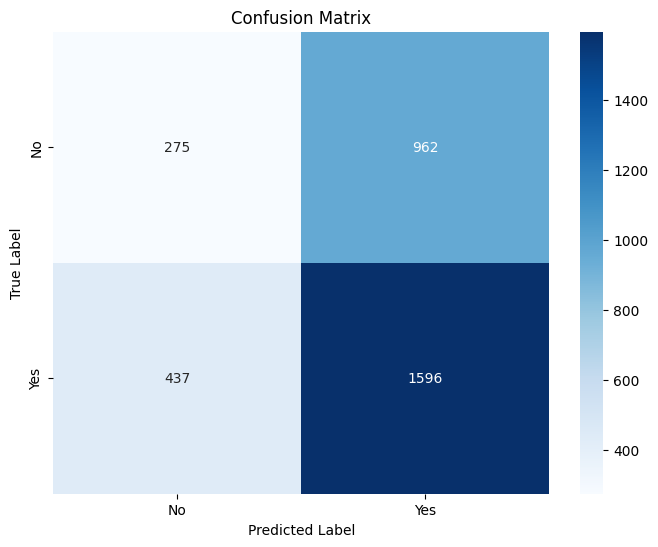

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(ground_truth, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No', 'Yes'],
            yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()